# Imports

In [1]:
import os

os.chdir("C:\\Users\\samue\\OneDrive\\Desktop\\CS701-Group-09-Project")

In [2]:
import cv2
import numpy as np

from src.data_processing.visualization import (
    process_training_ct_scan_metadata,
    process_test_ct_scan_metadata,
    visualize_segmentation_from_numpy_arrays,
    generate_sweetviz_report,
)
from src.data_processing.preprocessing import (
    apply_preprocessing_to_input_image,
    apply_preprocessing_to_label_mask,
    get_bounding_boxes,
)

from src.data_processing.loader import SAMSegmentationDataset, create_dataloader
from src.modeling.trainer import SAMTrainer
from src.modeling.inference import run_SAM_inference_and_save_masks

# Exploratory Data Analysis

In [3]:
train_data = process_training_ct_scan_metadata(
    train_images_directory="data/train_images/",
    train_labels_directory="data/train_labels/",
    spacing_file_path="data/metadata/spacing_mm.txt",
)

train_data.head(5)

,CT_ID,slice_count,data_split_type,spacing_X,spacing_Y,spacing_Z,slice_id,num_organs,Gallbladder,Stomach,Esophagus,Right Kidney,Right Adrenal Gland,Left Adrenal Gland,Liver,Left Kidney,Aorta,Spleen,Inferior Vena Cava,Pancreas
0,01,129,train,0.976562,0.976562,2.5,1,1,0.0,0.0000,0.0000,0.0,0.0,0.0,0.0000,0.0022,0.0000,0.0000,0.0000,0.0
1,01,129,train,0.976562,0.976562,2.5,10,1,0.0,0.0000,0.0000,0.0,0.0,0.0,0.0000,0.0101,0.0000,0.0000,0.0000,0.0
2,01,129,train,0.976562,0.976562,2.5,100,6,0.0,0.0042,0.0006,0.0,0.0,0.0,0.0784,0.0000,0.0018,0.0339,0.0019,0.0
3,01,129,train,0.976562,0.976562,2.5,101,6,0.0,0.0012,0.0007,0.0,0.0,0.0,0.0725,0.0000,0.0017,0.0319,0.0028,0.0
4,01,129,train,0.976562,0.976562,2.5,102,5,0.0,0.0000,0.0008,0.0,0.0,0.0,0.0623,0.0000,0.0018,0.0300,0.0026,0.0


In [4]:
test_data = process_test_ct_scan_metadata(
    test_images_directory="data/test_images/",
    spacing_file_path="data/metadata/spacing_mm.txt",
)

test_data.head(5)

,CT_ID,slice_count,data_split_type,spacing_X,spacing_Y,spacing_Z
0,51,54,test,0.769531,0.769531,5.0
1,52,94,test,0.769531,0.769531,2.5
2,53,68,test,0.683594,0.683594,3.0
3,54,101,test,0.644531,0.644531,2.5
4,55,93,test,0.863281,0.863281,2.5


Labels in segmentation mask and corresponding organs:
Label 0: Background
Label 4: Right Kidney
Label 7: Liver
Label 9: Aorta
Label 11: Inferior Vena Cava


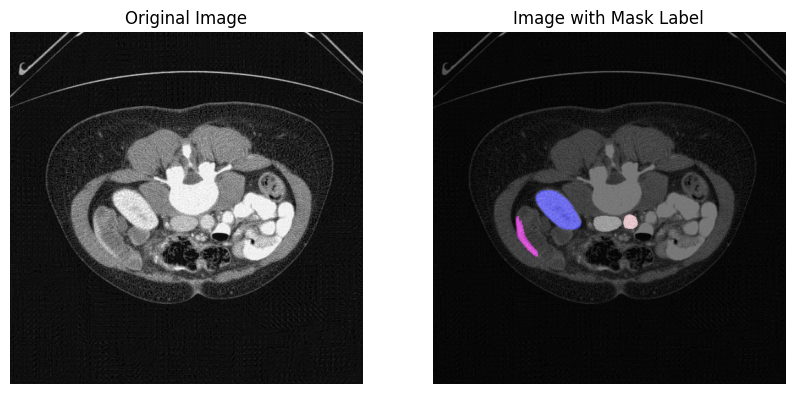

In [5]:
image = cv2.imread("data/train_images/33/15.png", cv2.IMREAD_GRAYSCALE)
mask = cv2.imread("data/train_labels/33/15.png", cv2.IMREAD_GRAYSCALE)

visualize_segmentation_from_numpy_arrays(image, mask)

In [6]:
# generate_sweetviz_report(
#     train_data, report_filename="results/EDA/train_data_EDA_report.html"
# )

# generate_sweetviz_report(
#     test_data, report_filename="results/EDA/test_data_EDA_report.html"
# )

# Data Preprocessing

Labels in segmentation mask and corresponding organs:
Label 0: Background
Label 4: Right Kidney
Label 7: Liver
Label 9: Aorta
Label 11: Inferior Vena Cava


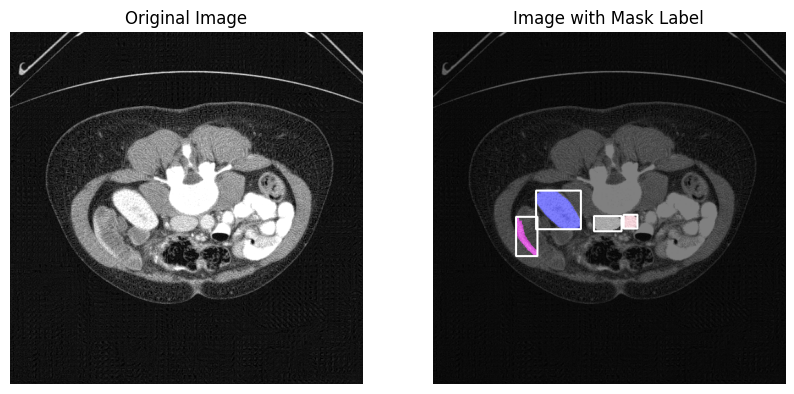

In [7]:
processed_image_sample = apply_preprocessing_to_input_image(image)

bounding_boxes_dict = get_bounding_boxes(mask, "33", 15)

list_of_bounding_boxes = [
    bounding_box for _, bounding_box in bounding_boxes_dict.items()
]

visualize_segmentation_from_numpy_arrays(
    processed_image_sample, mask, list_of_bounding_boxes
)

# Modeling

In [8]:
pretrained_model_name = "wanglab/medsam-vit-base"

In [9]:
train_dataset = SAMSegmentationDataset(
    image_dir="data/train_images",
    mask_dir="data/train_labels",
    spacing_metadata_dir="data/metadata/spacing_mm.txt",
    processor=pretrained_model_name,
)

print(f"Number of records: {len(train_dataset)}")
print(f"Example of one record:")
for k, v in train_dataset[0].items():
    print(f"{k}: {v.shape}")

test_dataset = SAMSegmentationDataset(
    image_dir="data/test_images",
    bbox_file_dir="data/metadata/test1_bbox.txt",
    spacing_metadata_dir="data/metadata/spacing_mm.txt",
    processor=pretrained_model_name,
)

print("\n====================\n")
print(f"Number of records: {len(test_dataset)}")
print(f"Example of one record:")
for k, v in test_dataset[0].items():
    try:
        print(f"{k}: {v.shape}")
    except:
        print(f"{k}: {v}")

train_dataloader = create_dataloader(
    train_dataset,
    batch_size=36,
    train_ratio=0.8,
    shuffle=True,
    num_workers=2,
)

batch = next(iter(train_dataloader))

print("\n====================\n")
print(f"Example of one batch:")
for k, v in batch.items():
    print(f"{k}: {v.shape}")

Number of records: 22484
Example of one record:
pixel_values: torch.Size([3, 1024, 1024])
original_sizes: torch.Size([2])
reshaped_input_sizes: torch.Size([2])
input_boxes: torch.Size([1, 4])
ground_truth_mask: torch.Size([512, 512])


Number of records: 6543
Example of one record:
pixel_values: torch.Size([3, 1024, 1024])
original_sizes: torch.Size([2])
reshaped_input_sizes: torch.Size([2])
input_boxes: torch.Size([1, 4])
image_path: data/test_images\51\1.png


Example of one batch:
pixel_values: torch.Size([36, 3, 1024, 1024])
original_sizes: torch.Size([36, 2])
reshaped_input_sizes: torch.Size([36, 2])
input_boxes: torch.Size([36, 1, 4])
ground_truth_mask: torch.Size([36, 512, 512])


In [10]:
trainer = SAMTrainer(
    model_name=pretrained_model_name,
    device="cpu",  # Use GPU (cuda) if available
    learning_rate=1e-5,
    weight_decay=0,
)

In [11]:
# model.k_fold_cross_validation(
#     dataloader=train_dataloader,  # SAM DataLoader object
#     k_folds=5,  # Default: 5 folds
#     num_epochs=10,  # Default: 10 epochs per fold
# )

In [12]:
# run_SAM_inference_and_save_masks(
#     model=trainer.model,
#     test_dataset=test_dataset,
#     batch_size=1,
#     device="cpu",
# )

In [13]:
# image = cv2.imread("data/test_images/51/1.png", cv2.IMREAD_GRAYSCALE)
# mask = cv2.imread("data/test_labels/51/1.png", cv2.IMREAD_GRAYSCALE)

# mask = cv2.resize(mask, (512, 512), interpolation=cv2.INTER_NEAREST)
# mask = (mask > 0).astype(np.uint8)

# visualize_segmentation_from_numpy_arrays(image, mask, [[274, 192, 313, 255]], from_inference=True)